# Kernel density estimation bandwidth selection
**TLDR**

Here are the final recommendations for kernel density estimation based on the experiments below:

1. Use parallelism over input data to speed up evaluation when needed.
2. Use package *scipy.stats gaussian_kde* for speed advantage over scikit-learn in kernel density estimation and scale invariance.
3. Use Silverman rule-of-thumb bandwidth estimation - fit looks good compared to time/effort spent optimizing the bandwidth for each case.

*N.B.*: Scikit-learn's *KernelDensity* appears to be sensitive to scale - performance is **much** better on standard scaled data than raw data.

**TODO**
This should be in benchmarking.

**Notebook description**

In the following notebooks, two engineered features will be introduced. Both are based on the Kullback-Leibler divergence (KLD) of the distributions of the underlying feature in human and synthetic text. Kernel density estimation (KDE) will be used to recover the distributions of both the underlying features and then the Kullback-Leibler divergence. Therefore, it is important to do a reasonable job of kernel density estimation. The individual features should not be too hard - they are all approximately normally distributed - in fact, a gaussian fits well enough. But, improvements can be made, especially so in the case of the KLD which is not easily modeled by an 'off the shelf' statistical distribution. In early experiments, kernel density estimation has done a reasonable job, however:

1. It's slow, possibly due to poorly specified bandwidth or kernel.
2. Default values are used for kernel type and bandwidth.
3. There are two options for gaussian kernel density estimation: SciPy's *gaussian_kde* and SciKit-Learn's *KernelDensity*.

The plan is to test these factors with real data and make some informed choices about the best strategy moving forward.

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Do the imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

import configuration as config
import functions.helper as helper_funcs

Working directory: /mnt/arkk/llm_detector/classifier


## 2. Load and prepare the data
Load and prepare some data to test on. Rather than working with all of the length bins, the combined training dataset will be used for testing purposes.

<class 'pandas.core.frame.DataFrame'>
Index: 39069 entries, 0 to 39068
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   39069 non-null  int64  
 1   Fragment length (tokens)  39069 non-null  int64  
 2   Source                    39069 non-null  object 
 3   String                    39069 non-null  object 
 4   Perplexity                39069 non-null  float64
 5   Cross-perplexity          39069 non-null  float64
 6   Perplexity ratio score    39069 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 2.4+ MB


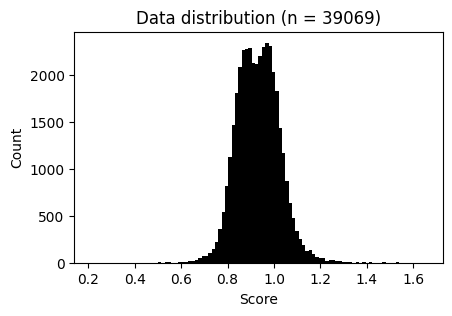

In [2]:
# The dataset to load omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas
data_lake = pd.HDFStore(input_file)

# Load the dataframe
data_df = data_lake[f'training/combined/features']

# Close the connection to the data lake
data_lake.close()

# Take a look
data_df.info()

# Get the perplexity ratio score data
data = np.asarray(data_df['Perplexity ratio score'])

# Show a quick histogram
plt.figure(figsize = (4.75, 3))
plt.title(f'Data distribution (n = {len(data)})')
plt.hist(data, bins = 100, color = 'black')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

## 3. Visual comparison of fits: bandwidth

In [3]:
def kde_bandwidth_scan(
        data: np.array,
        bandwidths: list
) -> dict:

    '''Takes 1D dataset and does gaussian KDE with SciPy and scikit-learn for a list of bandwidths'''

    # Pick a set of sample points which span the range of the input data to use for evaluation
    x = helper_funcs.make_padded_range(data)

    # Empty dictionary to store results
    results = {}

    # Add empty lists for other values
    results['Package'] = []
    results['Bandwidth'] = []
    results['x'] = []
    results['y'] = []

    # Loop on the bandwidths to test
    for bandwidth in bandwidths:

        # Get KDEs for specified bandwidth
        scipy_kde = gaussian_kde(
            data.flatten(), 
            bw_method = bandwidth
        )

        scikit_kde = KernelDensity(
            kernel = 'gaussian',
            bandwidth = bandwidth
        ).fit(data.reshape(-1, 1))

        # Get the SciPy KDE's values at the sample points
        y = scipy_kde(x)
        
        # Clip data back to original range, and add to results
        for xi, yi in zip(x.flatten(), y.flatten()):
            if xi >= min(data) and xi <= max(data):
                results['Package'].append('SciPy')
                results['Bandwidth'].append(bandwidth)
                results['x'].append(xi)
                results['y'].append(yi)

        # Get the scikit KDE's values at the sample points
        log_y = scikit_kde.score_samples(x.reshape(-1, 1))
        y = np.exp(log_y)

        # Clip data back to original range, and add to results
        for xi, yi in zip(x.flatten(), y.flatten()):
            if xi >= min(data) and xi <= max(data):
                results['Package'].append('scikit-learn')
                results['Bandwidth'].append(bandwidth)
                results['x'].append(xi)
                results['y'].append(yi)

    results = pd.DataFrame(results)

    return results

In [4]:
def plot_bandwidth_scan(result: pd.DataFrame, data: np.array) -> plt:
    '''Takes results dataframe from kde_bandwidth_scan() and plots it.'''

    # Set up a 1 x 2 figure for some diagnostic plots
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Add figure title
    fig.suptitle('Gaussian kernel density estimation: bandwidth selection\n', y=1.01, fontsize='x-large')

    # Add labels and the histogram to each plot
    axs[0].set_title('SciPy gaussian_kde')
    axs[0].hist(data, bins = 100, density = True, color = 'grey', label = 'Data')
    axs[0].set_xlabel('Score')
    axs[0].set_ylabel('density')

    axs[1].set_title('scikit-learn KernelDensity')
    axs[1].hist(data, bins = 100, density = True, color = 'grey')
    axs[1].set_xlabel('Score')
    axs[1].set_ylabel('density')

    # Get bandwidths used in experiment
    bandwidths = result['Bandwidth'].unique()

    # Loop on bandwidths
    for bandwidth in bandwidths:

        bandwidth_data = result[result['Bandwidth'] == bandwidth]

        # Plot SciPy data
        scipy_data = bandwidth_data[bandwidth_data['Package'] == 'SciPy']
        axs[0].plot(scipy_data['x'], scipy_data['y'], label = f'Bandwidth: {bandwidth}')

        # Plot scikit-learn data
        scikit_data = bandwidth_data[bandwidth_data['Package'] == 'scikit-learn']
        axs[1].plot(scikit_data['x'], scikit_data['y'])

    fig.subplots_adjust(right = 0.78)
    fig.legend(loc = 7)
    
    return plt

### 3.1 Raw data

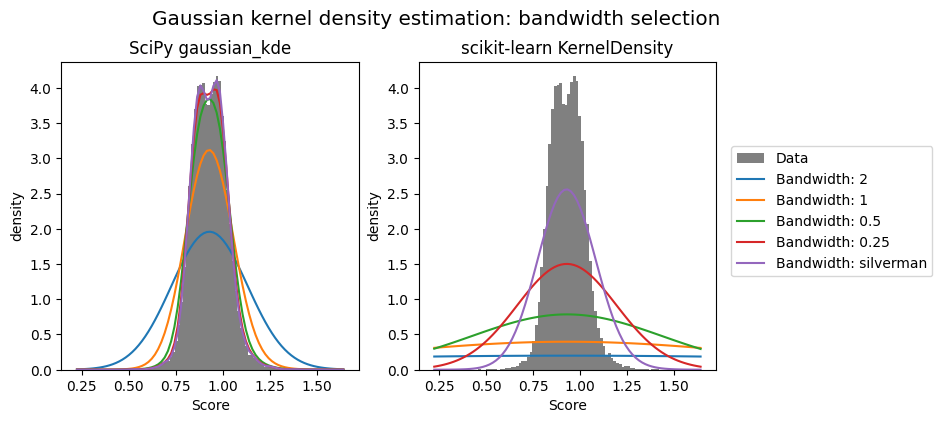

In [5]:
result = kde_bandwidth_scan(
    data = data,
    bandwidths = [2, 1, 0.5, 0.25, 'silverman']
)

plot_bandwidth_scan(result, data).show()

### 3.2 Standardized data

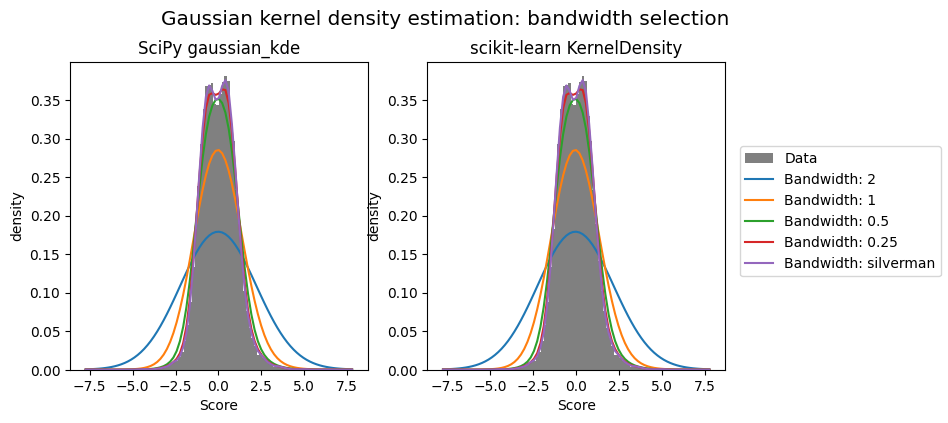

In [6]:
feature_scaler = StandardScaler().fit(np.asarray(data_df['Perplexity ratio score']).reshape(-1, 1))
scaled_data = feature_scaler.transform(np.asarray(data_df['Perplexity ratio score']).reshape(-1, 1))

result = kde_bandwidth_scan(
    data = scaled_data,
    bandwidths = [2, 1, 0.5, 0.25, 'silverman']
)

plot_bandwidth_scan(result, scaled_data).show()

That was unexpected - The results from scikit-learn and SciPy look identical, but only if the data is standard scaled! Scikit-learn seems to require standard scaled data? Don't have time to dig into why right now, but word-to-the-wise, if you are going to use scikit-learn for kernel density estimation, be sure to convert your data to Z-scores first. 

Also, the silverman bandwidth estimate look perfectly fine. Not convinced there is much improvement to be had by fine tuning the bandwidth using cross-validation or the like. Let's move on to speed.

## 4. KDE speed
Using the Silverman rule for bandwidth, measure the dependence of KDE speed on dataset size. There are two parts to this:
1. Speed of kernel density estimation vs dataset size
2. Speed of fitted value calculation vs number of evaluation points (this should scale linearly)

### 4.1. Kernel density estimation speed vs dataset size

In [7]:
def kde_speed(
    data: np.array,
    sample_sizes: list,
    replicates: int = 50
) -> dict:
    
    '''Takes a 1D array of data, and a list sample sizes. Does
    KDE with SciPy and scikit-learn for each sample size and 
    measures time. Returns results in a dictionary.'''

    # Empty dictionary to store results
    results = {}

    # Add empty lists for other values
    results['Replicate'] = []
    results['Package'] = []
    results['Sample size'] = []
    results['Mean time (sec.)'] = []
    results['Standard deviation'] = []

    # Loop on sample sizes
    for sample_size in sample_sizes:

        # Get the sample
        sample = np.random.choice(data.flatten(), size = sample_size)

        # Collectors for replicate data
        scipy_times = []
        scikit_times = []

        # Loop on replicates
        for i in range(replicates):

            # Do the KDEs, timing how long it takes

            # SciPy
            start_time = time.time()

            _ = gaussian_kde(
                sample,#.flatten(), 
                bw_method = 'silverman'
            )

            scipy_times.append(time.time() - start_time)

            # scikit-learn
            start_time = time.time()

            _ = KernelDensity(
                kernel = 'gaussian',
                bandwidth = 'silverman'
            ).fit(sample.reshape(-1, 1))

            scikit_times.append(time.time() - start_time)

        # Add results
        results['Replicate'].append(i)
        results['Package'].append('SciPy')
        results['Sample size'].append(sample_size)
        results['Mean time (sec.)'].append(np.mean(scipy_times))
        results['Standard deviation'].append(np.std(scipy_times))

        results['Replicate'].append(i)
        results['Package'].append('scikit-learn')
        results['Sample size'].append(sample_size)
        results['Mean time (sec.)'].append(np.mean(scikit_times))
        results['Standard deviation'].append(np.std(scikit_times))

    return results

In [8]:
sample_sizes = [500, 1000, 2000, 4000, 8000, 16000]

result = kde_speed(
    data = data,
    sample_sizes = sample_sizes
)

result = pd.DataFrame(result)
result.head()

,Replicate,Package,Sample size,Mean time (sec.),Standard deviation
0,49,SciPy,500,0.000353,0.000052
1,49,scikit-learn,500,0.000507,0.000023
2,49,SciPy,1000,0.000302,0.000037
3,49,scikit-learn,1000,0.000531,0.000022
4,49,SciPy,2000,0.000311,0.000012


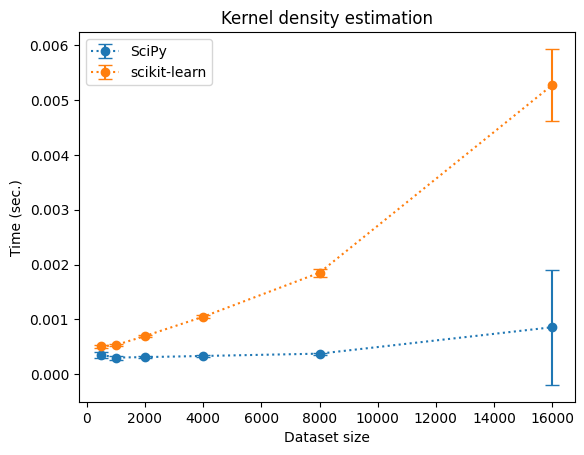

In [9]:
plt.title('Kernel density estimation')
plt.xlabel('Dataset size')
plt.ylabel('Time (sec.)')

scipy_data = result[result['Package'] == 'SciPy']

plt.errorbar(
    scipy_data['Sample size'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'SciPy'
)

scipy_data = result[result['Package'] == 'scikit-learn']

plt.errorbar(
    scipy_data['Sample size'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'scikit-learn'
)

plt.legend(loc = 'upper left')
plt.show()

Scipy has much better scaling characteristics. Scikit-learn starts to slow down significantly as the dataset grows.

### 4.2. Fitted value calculation speed vs number of evaluation points

In [10]:
def fitted_value_speed(
    data: np.array,
    n_eval_points: list,
    replicates: int = 5
) -> dict:
    
    '''Takes a 1D array of data, and a list evaluation point counts. Does
    KDE with SciPy and scikit-learn and then times the evaluation at each n 
    evaluation points, measures time. Returns results in a dictionary.'''

    # Do the KDEs

    # SciPy
    scipy_kde = gaussian_kde(
        data.flatten(), 
        bw_method = 'silverman'
    )

    # scikit-learn
    scikit_kde = KernelDensity(
        kernel = 'gaussian',
        bandwidth = 'silverman'
    ).fit(data.reshape(-1, 1))

    # Empty dictionary to store results
    results = {}

    # Add empty lists for other values
    results['Replicate'] = []
    results['Package'] = []
    results['Evaluation points'] = []
    results['Mean time (sec.)'] = []
    results['Standard deviation'] = []

    # Loop on evaluation point numbers 
    for n in n_eval_points:

        # Generate evaluation points
        x = helper_funcs.make_padded_range(data, n)

        # Collectors for replicate data
        scipy_times = []
        scikit_times = []

        # Loop on replicates
        for i in range(replicates):

            # Do the evals, timing how long it takes

            # SciPy
            start_time = time.time()
            _ = scipy_kde(x)
            scipy_times.append(time.time() - start_time)

            # scikit-learn
            start_time = time.time()
            log_y = scikit_kde.score_samples(x.reshape(-1, 1))
            _ = np.exp(log_y)
            scikit_times.append(time.time() - start_time)

        # Add results
        results['Replicate'].append(i)
        results['Package'].append('SciPy')
        results['Evaluation points'].append(n)
        results['Mean time (sec.)'].append(np.mean(scipy_times))
        results['Standard deviation'].append(np.std(scipy_times))

        results['Replicate'].append(i)
        results['Package'].append('scikit-learn')
        results['Evaluation points'].append(n)
        results['Mean time (sec.)'].append(np.mean(scikit_times))
        results['Standard deviation'].append(np.std(scikit_times))

    return results

In [11]:
n_eval_points = [500, 1000, 2000, 4000, 8000, 16000]

result = fitted_value_speed(
    data = data,
    n_eval_points = n_eval_points
)

result = pd.DataFrame(result)
result.head()

,Replicate,Package,Evaluation points,Mean time (sec.),Standard deviation
0,4,SciPy,500,0.420854,0.000767
1,4,scikit-learn,500,1.329158,0.013651
2,4,SciPy,1000,0.796230,0.001554
3,4,scikit-learn,1000,2.689859,0.041483
4,4,SciPy,2000,1.551620,0.010648


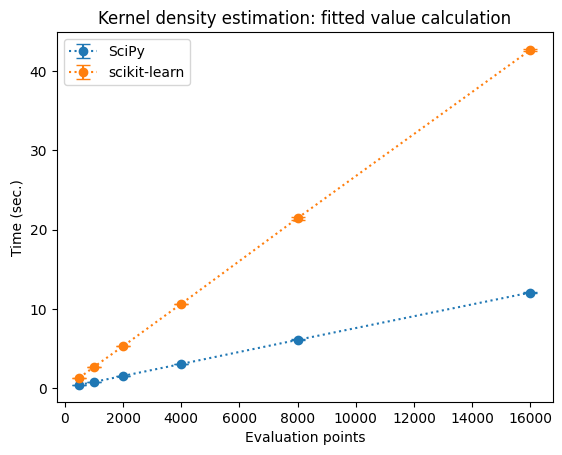

In [12]:
plt.title('Kernel density estimation: fitted value calculation')
plt.xlabel('Evaluation points')
plt.ylabel('Time (sec.)')

scipy_data = result[result['Package'] == 'SciPy']

plt.errorbar(
    scipy_data['Evaluation points'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'SciPy'
)

scipy_data = result[result['Package'] == 'scikit-learn']

plt.errorbar(
    scipy_data['Evaluation points'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'scikit-learn'
)

plt.legend(loc = 'upper left')
plt.show()

Not as big of a difference for evaluation speed, but SciPy is slightly better. Here are the recommendations so far:
1. Package *scipy.stats gaussian_kde*
2. Bandwidth: Silverman rule-of-thumb estimation

### 4.3. Fitted value calculation: data parallelism
Can we speed up evaluation by breaking the points into chunks and evaluating them in parallel?

In [13]:
import numpy as np
import multiprocessing

def parallel_score_samples(kde: gaussian_kde, data: np.array, workers: int):
    '''Splits evaluation over n_workers.'''

    with multiprocessing.Pool(workers) as p:
        return np.concatenate(p.map(kde, np.array_split(data, workers)))

# kde = KernelDensity(bandwidth=2.0).fit(sample) 
# kde_result = parallel_score_samples(kde, sample)

def eval_speed_worker_count(data: np.array, worker_counts: list, replicates: int = 3) -> dict:
    '''Tests evaluation speed with range of worker counts.'''

    # SciPy KDE
    scipy_kde = gaussian_kde(
        data.flatten(), 
        bw_method = 'silverman'
    )

    # Generate evaluation points
    x = helper_funcs.make_padded_range(data, 16000)

    # Empty dictionary to store results
    results = {}

    # Add empty lists for other values
    results['Replicate'] = []
    results['Workers'] = []
    results['Mean time (sec.)'] = []
    results['Standard deviation'] = []

    # Loop worker counts 
    for worker_count in worker_counts:

        # Collector for replicate data
        times = []

        # Loop on replicates
        for i in range(replicates):

            # Do the eval, timing how long it takes
            start_time = time.time()
            _ = parallel_score_samples(
                kde = scipy_kde,
                data = x,
                workers = worker_count
            )
            times.append(time.time() - start_time)

        # Add results
        results['Replicate'].append(i)
        results['Workers'].append(worker_count)
        results['Mean time (sec.)'].append(np.mean(times))
        results['Standard deviation'].append(np.std(times))

    return results

In [14]:
worker_counts = [1, 2, 4, 8, 16]

result = eval_speed_worker_count(
    data = data,
    worker_counts = worker_counts, 
    replicates = 3
)

result = pd.DataFrame(result)
result.head()

,Replicate,Workers,Mean time (sec.),Standard deviation
0,2,1,12.123972,0.081471
1,2,2,6.238817,0.002146
2,2,4,3.349180,0.003508
3,2,8,2.118734,0.006784
4,2,16,1.806696,0.053817


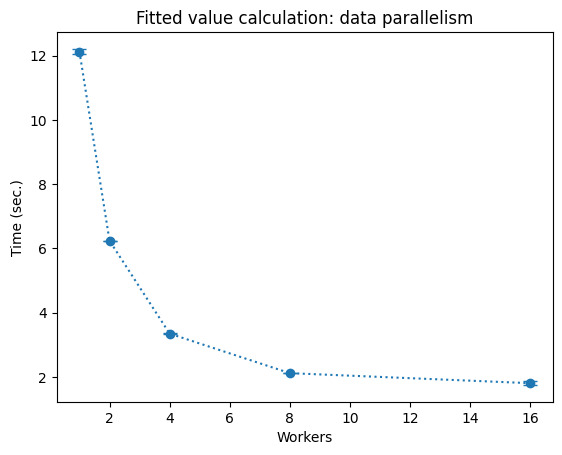

In [15]:
plt.title('Fitted value calculation: data parallelism')
plt.xlabel('Workers')
plt.ylabel('Time (sec.)')

plt.errorbar(
    result['Workers'], 
    result['Mean time (sec.)'], 
    yerr = result['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5
)

plt.show()

Nice! Excellent speed-up with increased worker count.
## 5. Conclusion
Here are the final recommendations based on the above experiments:

1. Use parallelism over input data to speed up evaluation when needed.
2. Use package *scipy.stats gaussian_kde* for speed advantage in kernel density estimation and scale invariance
3. Silverman rule-of-thumb bandwidth estimation - fit looks good compared to time/effort spent optimizing the bandwidth for each case